#  Reinforcement Learning part 2: Generalizability, Q-Learning enhancements and function approximators

Reinforcement Learning is a general framework for building computational agents which can, if trained properly, act intelligently in a well-defined but dynamic environment.  Interesting applications of this paradigm include game AI (e.g., AlphaGo and self-playing Atari and Nintendo games), as well as various challenging problems in mechanical control and robotics.

In this notebook we continue our introduction to the fundamentals of Reinforcement Learning and discuss:

- several important enhancements to Q-Learning
- the strengths and shortcomings of a fully trained agent
- large state spaces and the necessity for generic function approximators (e.g., kernels, neural networks, and trees)


>The content of this notebook is supplementary material for the textbook Machine Learning Refined (Cambridge University Press, 2016). Visit http://www.mlrefined.com for free chapter downloads and tutorials, and [our Amazon site here](https://www.amazon.com/Machine-Learning-Refined-Foundations-Applications/dp/1107123526/ref=sr_1_1?ie=UTF8&qid=1474491657&sr=8-1&keywords=machine+learning+refined) for details regarding a hard copy of the text.

#  1.  How generalizable is a trained agent?

At the end of the last notebook we trained a fully-functional gridworld agent on a maze world.  Lets reproduce that result quickly for easy reference.  We initialize the gridworld in the next cell, train it in the second cell using the basic Q-Learning algorithm discussed in the previous notebook, and use the learned optimal policy function to move effeciently through the maze starting at a number of intitial locations.

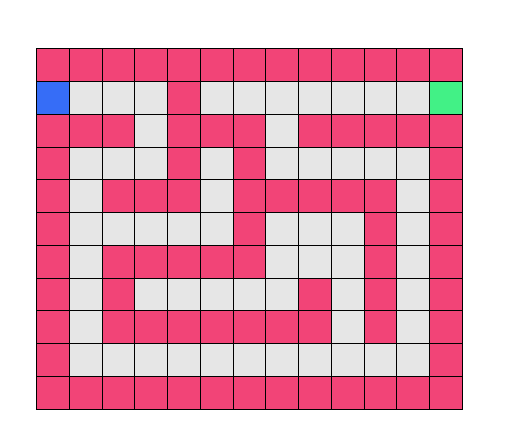

In [27]:
# import gridworld library - make sure this is executed prior to running any gridworld cell
import sys
sys.path.append('demo_python_backend_files')
%matplotlib inline

# import custom gridworld simulator 
from gridworld_lib import gridworld_enviro

# generate instance of gridworld
small_maze = gridworld_enviro.environment(world_size = 'small', world_type = 'maze')

# show the grid
small_maze.color_gridworld(lights = 'on')

In [22]:
# import q-learning module
from gridworld_lib import gridworld_qlearn

# create an instance of the q-learner
small_maze_qlearner = gridworld_qlearn.learner(gridworld = small_maze)

In [ ]:
# run q-learning
small_maze_qlearner.train(verbose = False, action_method = 'exploit', gamma = 0,training_episodes = 100,exploit_param = 0.5)
blah = small_maze_qlearner.time_per_episode
print sum(blah)

small_maze_qlearner.train(verbose = False, action_method = 'exploit', gamma = 0.5,training_episodes = 100,exploit_param = 0.5)
blah2 = small_maze_qlearner.time_per_episode
print sum(blah2)

small_maze_qlearner.train(verbose = False, action_method = 'exploit', gamma = 1,training_episodes = 100,exploit_param = 0.5)
blah3 = small_maze_qlearner.time_per_episode
print sum(blah3)

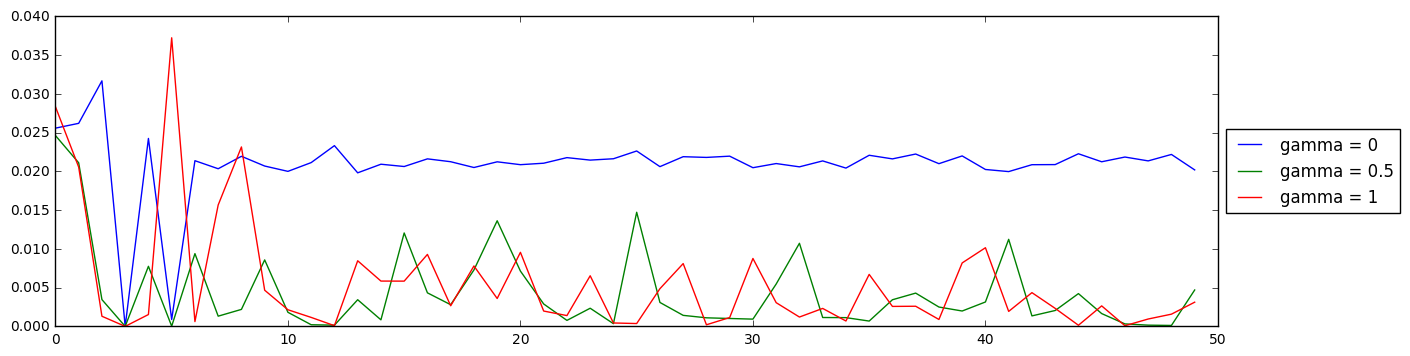

In [20]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (15,4))
ax = fig.add_subplot(111)
ax.plot(blah)
ax.plot(blah2)
ax.plot(blah3)

ax.legend(['gamma = 0','gamma = 0.5','gamma = 1'],loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

In [ ]:
# load in gridworld animation module
from gridworld_lib import gridworld_animators

# create instance of animator
animator = gridworld_animators.animator()

# animate a fully trained agent 
locs = [[9,0],[5,5],[1,1],[7,3]]
animator.animate_validation_runs(gridworld = small_maze,learner = small_maze_qlearner,starting_locations = locs,lights='on')

Works quite well!

How well will our trained agent - trained on the maze enviroment - perform if we set it loose on a different enviroment?  Lets experiment and find out.  Below we load in the 'moat' world and set our learned agent loose on it.

In [ ]:
# import custom gridworld simulator 
from gridworld_lib import gridworld_enviro

# generate instance of gridworld
small_moat = gridworld_enviro.environment(world_size = 'small', world_type = 'moat')

# show the enviroment
small_moat.color_gridworld()

In [ ]:
# load in gridworld animation module
from gridworld_lib import gridworld_animators

# create instance of animator
animator = gridworld_animators.animator()

# animate a fully trained agent 
locs = [[0,0]]
animator.animate_validation_runs(gridworld = small_moat,learner = small_maze_qlearner,starting_locations = locs)

Oof!  

The fully trained agent - again, trained on the small enviroment, **not** the small moat enviroment - does not perform well on the small moat enviroment at all!  

Sure the enviroment the agent was trained on was a gridworld - but it was still *very* different than the one we tested the agent on.  Our agent gained **all** of its experience on something very different than what we tested it on.  So - should we be surprised by this 'failing'?  No.   

AI / machine learning is all about creating pattern recognizers that - when trained properly on a dataset - generalize from what they have seen in training to making accurate predictions on new input data.  If a pattern recognizer isn't trained on the sort of data we would like it to recognize in the future we can't expect miracles to happen.  

So generally speaking, we cannot expect an RL agent trained on one enviroment to perform well on another substantially different one.  To demand this is like expecting an object detector - trained to recognize human faces on a large set of images - to accurately detect cars in a new set of images.  In both training and testing we use the same 'enviroment' - images' - but what we want our 'agent' to in each instance is quite different.

# 2.  Simple yet powerful enhancements to Q-Learning

In the first notebook we defined the recursive update equation that lies at the heart of Q-Learning

$$Q\left(s_{k-1},\,a_{k}\right)=r_{k}+\underset{i=1...M}{\text{maximum}}\,\,Q\left(s_{k},\,\alpha_{i}\right)$$

Remember that in theory the term on the left hand side of the equation $Q\left(s_{k-1},\,a_{k}\right)$ stands for the maximum possible reward we recieve if we start at state $s_{k-1}$ and take action $a_k$.  This is equal to the sum of the two terms on the right hand side above - these are

- $r_k$: which stands for the immediate **short-term reward** we recieve for taking action $a_k$ starting from state $s_{k-1}$


- $\underset{i=1...M}{\text{maximum}}\,\,Q\left(s_{k},\,\alpha_{i}\right)$: which stands for the maximum **long-term reward** we recieve for taking action $a_k$ starting from state $s_{k-1}$

Of course when we begin training neither term on the left and right involving $Q$ gives us a maximal value - thats why we have to train in the first place!  This recursive step was derived *assuming* Q was optimal, and we use it with Q-Learning to approximately determine such a Q function.

Practically speaking then we can make several adjustments to the basic Q-Learning algorithm to compensate for the fact that the optimal Q - and hence the validity of the recurisve update step - takes several episodes of simulation to resolve properly. 

## 2.1  Choosing training actions according to exploration/exploitation trade-off

One glaring ineffeciency in the basic Q-Learning algorithm cries out for improvement: how actions are chosen during each step of a training episode.  Remember that in the most basic version of Q-Learning actions are taken *randomly* while training, and then according to the optimal policy

$$i^{\star}=\underset{i=1...M}{\text{argmax}}\,\,Q\left(s_{k},\,\alpha_{i}\right)$$

when validating.  

The ineffeciency of taking random actions while training becomes more palpable if we simply look at the total rewards per episode of training on one of our small gridworld enviroments.  We do this in the next cell for the small maze gridworld - which we trained above for 500 training episodes.  During each simulation episode we record the total reward gained, and now we plot the resulting per-episode total rewards.

In [ ]:
import matplotlib.pyplot as plt

# create figure
fig = plt.figure(figsize = (12,5))
ax = fig.add_subplot(1,1,1)

# plot total reward history
ax.plot(small_maze_qlearner.training_reward)

# clean up plot
ax.set_xlabel('episode')
ax.set_ylabel('average reward')
ax.set_title('training total rewards per episode history')
plt.show()

This is what we typically see when using random action selection for training an RL agent: the training *never improves from episode-to-episode even though $Q$ is getting better and better as we go along*.  Adjacently this means that the amount of computation time from episode-to-episode *stays roughly the same no matter how well we have resolved $Q$*.  

While traininng via random action taking does force us to *explore* the input space well during training, we never *exploit* the resolving $Q$ function (via optimal policy) during training to take actions.  After a while - at least - it seems clear that we don't need to rely completely on random action taking.  We can use our (partially) resolved $Q$ to take proper actions while training.  As $Q$ becomes more and more optimal this would clearly lower our training time in later episodes - since we are taking optimal-ish actions instead of merely random ones.  

But when should we start exploiting our $Q$ function during training?  We already have a sense of what happens if we never do this - training is highly ineffecient.  On the other hand, if we start exploiting too soon and too much we might not explore enough of the state space to create a robust learner (taking random actions certainly does allow us to explore the space thoroughly).  

In practice there are various ways of applying this **exploration/exploitation trade-off** for choosing actions.  Most of these use a simple stochastic switch: at each step of an episode of simulation choose the next action randomly with a certain probability $p$, or optimally with probability $1-p$.  In the most naive approach the probability $p$ is simply fixed beforehand at some value between 0 and 1, and used for all steps/episodes of training.  More thoughtful implementations push $p$ towards zero as training proceeds - since as training proceeds we can trust $Q$ more and more.  

This **exploration / exploitation trade-off** provides a simple yet powerful augmentation of the basic Q-Learning scheme discussed in the previous notebook.  In words, this action switch looks as follows.

---
During a step starting from state $s_k$ choose a random number $r\in[0,1]$ uniformly at random and with a threshold $p$ where $0<p<1$ choose the next action according too

**if** $r < p$

$~~~~~~~~~$Choose $a_k$ randomly
  
**else** 

$~~~~~~~~~$Choose $a_k$ according to the optimal policy

---

### Example: exploration/exploitation on the small maze gridworld

To see how much even the naive approach - of choosing a probability $p$ and sticking with it for each step/episode of simulation - helps make training more effecient we perform a number of experiments which compare it to strictly random action-taking in the Python cells below.
The gridworld qlearning library has both methods built in, and we can change between the two using the 'action_method' argument (set to 'random' or 'exploit' for the random or exploration/exploitation action methods).  

In the next Python cell we run both Q-Learning action methods - the first where we choose strictly random actions versus where exploration/exploitation is used - for 500 training episodes (the same initial episode states are used with each algorithm).  The exploration/exploitation trade-off threshold is set to 0.5 for all runs. 

In [ ]:
### compare random versus exploit-based training 
# load in q-learning class
from gridworld_lib import gridworld_qlearn

# create a q-learner using random actions
random_qlearner = gridworld_qlearn.learner(gridworld = small_maze,action_method = 'random')

# create a q-learner using exploration/exploitation actions
exploit_qlearner = gridworld_qlearn.learner(gridworld = small_maze,action_method = 'exploit')

# train each: random and exploit-based learners
exploit_qlearner.train(verbose = False)
random_qlearner.train(verbose = False)

Having run both algorithms we can compare both on any of the 500 episodes by using the gridworld animator.  In the next Python cell we animate the first 100 steps of the very first episode of each method and show the result side-by-side (with random on the left and exploration/exploitation on the right).  You can scroll through both simultaneously by pressing the play button.  

Since it is the very first episode - and the $Q$ function has not yet been resolved to any real degree in either case - neither method appears to converge better than the other.

In [ ]:
# load in gridworld animation module
from gridworld_lib import gridworld_animators

# create instance of animator
animator = gridworld_animators.animator()

# run animator to compare action methods        
animator.animate_training_comparison(gridworld = small_maze,learner_1 = random_qlearner,learner_2 = exploit_qlearner, episode = 0)

But after just a few episodes of simulation the $Q$ function starts to take shape - and we can see by plotting the same comparison for episode 25 that now the exploration/exploitation method completes much faster, and with far greater total reward. 

In [ ]:
# load in gridworld animation module
from gridworld_lib import gridworld_animators

# create instance of animator
animator = gridworld_animators.animator()

# run animator to compare action methods
animator.animate_training_comparison(small_maze,random_qlearner,exploit_qlearner,25)

To get a bigger picture sense of the total cost savings we perform the above experiments over all 500 episodes of simulation - and plot the resulting total reward per-episode of both methods for comparison.  As one can see from the following two Python cells, the exploration/exploitation approach results in drastically reduced training costs (and training time).

In [ ]:
import time 

# activate this cell to see the Q learning algorithm used for gridworld above
from gridworld_lib import gridworld_qlearn

# compare random versus exploration/exploitation actions on training
training_rewards = []
methods = ['random','exploit']
for i in range(len(methods)):
    method = methods[i]
    
    # create instance of learner
    small_maze_qlearner = gridworld_qlearn.learner(gridworld = small_maze,action_method = method)
    
    # run q-learning
    start = time.clock()
    small_maze_qlearner.train(verbose = False)
    end = time.clock()
    value = (end - start)
    print 'method ' + str(method) + ' completed training in ' + str(value) + ' seconds'
    
    # record rewards and history
    training_rewards.append(small_maze_qlearner.training_reward)

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (12,5))
ax = fig.add_subplot(1,1,1)

for i in range(len(methods)):
    ax.plot(training_rewards[i])
ax.set_xlabel('episode')
ax.set_ylabel('average reward')
ax.set_title('training total rewards per episode history')
ax.legend(['action method = ' + str(methods[0]),'action method = ' + str(methods[1])],loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Example: exploration/exploitation on the large maze gridworld

These cost savings are even more impressive for larger problems.  For example, we repeat the experiments above for a much larger version of the gridworld maze in the Python cells that follow. 

In [ ]:
# import gridworld library - make sure this is executed prior to running any gridworld cell
import sys
sys.path.append('demo_python_backend_files')
%matplotlib inline

# import custom gridworld simulator 
from gridworld_lib import gridworld_enviro

# generate instance of gridworld
large_maze = gridworld_enviro.environment(world_size = 'large', world_type = 'maze')

# show the grid
large_maze.color_gridworld()

In [ ]:
# activate this cell to see the Q learning algorithm used for gridworld above
from gridworld_lib import gridworld_qlearn
import time 

# compare random versus exploration/exploitation actions on training
training_rewards = []
methods = ['random','exploit']
for i in range(len(methods)):
    method = methods[i]
    
    # create instance of learner
    large_maze_qlearner = gridworld_qlearn.learner(gridworld = large_maze,action_method = method)
    
    # run q-learning
    start = time.clock()
    large_maze_qlearner.train(verbose = False)
    end = time.clock()
    value = (end - start)
    print 'method ' + str(method) + ' completed training in ' + str(value) + ' seconds'
    
    # record rewards and history
    training_rewards.append(large_maze_qlearner.training_reward)

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (12,5))
ax = fig.add_subplot(1,1,1)

for i in range(len(methods)):
    ax.plot(training_rewards[i])
ax.set_xlabel('episode')
ax.set_ylabel('average reward')
ax.set_title('training total rewards per episode history')
ax.legend(['action method = ' + str(methods[0]),'action method = ' + str(methods[1])],loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## 2.2  Short-term / long-term trade-off parameter

If it is possible that - at least in the first iterations of Q-Learning - that the long-term reward isn't that trustworthy, why don't we dampen its contribution to the update?  To do this we add a parameter (sometimes referred to as a penalty parameter or regularization parameter) to the long term reward.  This *short-term / long-term trade-off parameter* is tacked on to the long-term reward, and is often denoted by $\gamma$.  With the trade-off parameter included our recursion update formula takes a similar form as

$$Q\left(s_{k-1},\,a_{k}\right)=r_{k}+\gamma\cdot\underset{i=1...M}{\text{maximum}}\,\,Q\left(s_{k},\,\alpha_{i}\right)$$

We constrain $\gamma \in [0,1]$ so that by scaling $\gamma$ up and down we can tune the influence short-term versus long-term rewards have on how $Q$ is learned.  In particular by

- setting $\gamma$ to a smaller value we more heavily weight the contribution of the short-term reward $r_k$.  In this case our agent learns to take a more *greedy* approach to accomplishing our goal, at each state taking the next step that essentially maximizes the short-term reward only.


- setting $\gamma$ closer to $1$ then we have our original cost function, where we take into account equal contributions of both short-term and long-term rewards.

As with the exploration/exploitation tradeoff, one typically either naively sets $\gamma$ to a fixed value for all steps/episodes changes its value from episode-to-episode according to a pre-defined schedule.  

---------
### Q -learning pseudo-code
Initialize $Q$, exploration/exploitation threshold $p\in[0,1]$, and short-term/long-term tradeoff $\gamma\in[0,1]$ 

**for** e = 1...E (the maximum number of episodes)
    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Select a random initial state $s_0$ and set $k=1$
    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **while** end state not reached AND maximum iteration count not met


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Choose random number $r\in[0,1]$ uniformly at random

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**if** $r < p$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Choose $a_k$ randomly
  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**else** 


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Choose $a_k$ according to the optimal policy

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Recieve** the next state $s_k$ and corresponding immediate reward $r_k$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Update** $Q$ as 
    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$Q\left(s_{k-1},\,a_{k}\right)=r_{k}+\gamma\cdot\underset{i=1...M}{\text{maximum}}\,\,Q\left(s_{k},\,\alpha_{i}\right)$
    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$k \longleftarrow k+1$

-----


<a id='bib_cell'></a>

## Notes and bibliography

[0] Harmon, Mance E., and Stephanie S. Harmon. Reinforcement Learning: A Tutorial. No. WL-TR-97-1028. WRIGHT LAB WRIGHT-PATTERSON AFB OH, 1997

[1]  There are many algorithms specifically designed to solve just this task - the most popular being [Dijkstra’s and A\* algorithms](http://www.redblobgames.com/pathfinding/a-star/introduction.html).  However the more flexible RL framework too provides great results.

[2] Lai, Matthew. "Giraffe: Using deep reinforcement learning to play chess." arXiv preprint arXiv:1509.01549 (2015).
APA	

[3]  Mnih, Volodymyr, et al. "Playing atari with deep reinforcement learning." arXiv preprint arXiv:1312.5602 (2013).
    
[4]  Image taken from http://ai.berkeley.edu/project_overview.html

[5] Watkins, Christopher JCH, and Peter Dayan. "Q-learning." Machine learning 8.3-4 (1992): 279-292.

[6]  Image taken from https://gym.openai.com/